#DeepDream with a few changes

This version of the DeepDream code has a few changes to the original code:
- varying stepsize and iteration count over the octaves
- optional class suppression
- optional maximum und blur filtering of activation layers
- a given image size for the first octave instead of a scale factor
- optional desaturation
- a utility function to load images from local paths and remote urls


In [12]:
import os, sys

# changing base path to caffe root folder
# this assumes that this notebook is one folder below /caffe
os.chdir('/home/ubuntu/caffe') 
    
# adding python folder to paths
# might not be necessary on your system or somewhere else
sys.path.insert(0, './python') 

# imports and basic notebook setup
import caffe
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format
import urllib, cStringIO
from cStringIO import StringIO

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']

def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

def showarray(a, fmt='png'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# utility function that loads an image, optionally limits
# the size and removes an alpha channel in case there is one
def loadImageFromUrlOrLocalPath(pathOrUrl, maxSideLength = 1024, previewImage = False ):
    if 'http' in pathOrUrl:
        file = cStringIO.StringIO(urllib.urlopen(pathOrUrl).read())
        png = PIL.Image.open(file)
    else: 
        png = PIL.Image.open(pathOrUrl)
    s = png.size
    if ( np.max(s) > maxSideLength ):
        ratio = float(maxSideLength)/float(np.max(s))
        png = png.resize([int(s[0]*ratio), int(s[1]*ratio)], PIL.Image.ANTIALIAS)
    
    if png.mode == 'RGBA':
        src = PIL.Image.new("RGB", png.size, (255, 255, 255))
        src.paste(png, mask=png.split()[3])
    else:
        src = png
        
    img = np.float32(src)
    if previewImage is True:
        showarray(img)
        
    return img

In [9]:
model_path = 'models/bvlc_googlenet/'
net_fn = model_path + 'deploy.prototxt'
param_fn = model_path + 'bvlc_googlenet.caffemodel'

mean = np.float32([104.0, 117.0, 123.0]) 

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True

open('tmp.prototxt', 'w').write(str(model))
net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = mean,
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB


In [10]:
def deepdream(net, base_img, 
              octave_n=4, start_size=224,
              iter_list=[100,30,10,10],
              start_jitter=32., end_jitter=16.,
              start_step_size=3., end_step_size=1.5, step_list = None,
              visualize=True,
              start_saturation = 0.0, end_saturation = 0.0, 
              invert = False, recalculateKeepEachOctave = False,
              keep = 2, dropTop=0, keepFactor = 1.0, 
              gamma = 1.0, suppressFactor = 0.0,
              layers=None, keepIndices = None, 
              blurSteps = 0,maximumRadius = 0,
              end='inception_4c/output',
              clip=True, **step_params):    
    
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    octave_scale = pow(float(start_size) / float(np.min(base_img.shape[-3:2])), 1.0 / float(octave_n-1) )
    
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, octave_scale,octave_scale), order=1))
     
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=4)
                
        layer = end
        if layers:
            layer = layers[octave % len(layers)]

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        iter_n = iter_list[octave%len(iter_list)]
        saturation = start_saturation + ((end_saturation - start_saturation) * octave) / octave_n
        jitter = start_jitter + ((end_jitter - start_jitter) * octave) / octave_n
        if step_list is None:
            step_size = start_step_size + ((end_step_size - start_step_size) * octave) / octave_n
        else:
            step_size = step_list[octave%len(step_list)]
            
        for i in xrange(iter_n):
            
            
            keepIndices = make_step(net, end=layer, clip=clip, jitter=jitter, 
                      step_size=step_size, saturation=saturation,
                      keepFactor = keepFactor, gamma = gamma,
                      keep = keep, dropTop = dropTop, invert = invert,
                      suppressFactor = suppressFactor,
                      keepIndices = keepIndices, blurSteps=blurSteps,maximumRadius=maximumRadius,
                       **step_params)
            if recalculateKeepEachOctave is True:
                keepIndices = None
            
            if i is 2 and math.isnan(vis.mean()):
                clear_output(wait=True)
                return deprocess(net, src.data[0]),keepIndices
            
            if visualize:
                vis = deprocess(net, src.data[0])
                if not clip: # adjust image contrast if clipping is disabled
                    vis = vis*(255.0/np.percentile(vis, 99.98))
                showarray(vis)
            
            print "size",h,"x",w
            print "saturation",saturation
            print "octave",octave,"/",octave_n," iteration",i,"/",iter_n
            print 'jitter', jitter
            print 'step_size', step_size
            clear_output(wait=True)
        
        
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
        
    # returning the resulting image
    return deprocess(net, src.data[0]),keepIndices

In [4]:
def make_step(net, step_size=1.5, end='inception_4c/output', jitter=32, 
              clip=True, saturation = 0.0, invert = False,
              dropTop = 0, keep = 1, keepFactor = 1.0, blurSteps = 0, maximumRadius = 0,
              gamma = 4.0, suppressFactor = 0.000001,
              keepIndices = None ):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is storred in Net's 'data' blob
    dst = net.blobs[end]
    
    # apply jitter shift
    ox, oy = np.random.randint(-jitter, jitter+1, 2) # use uniform distribution
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2)
    
    net.forward(end=end)
   
   
    cnv1 = np.array([[.006, .061, 0.242, 0.383, 0.242, 0.61, .006]])
    cnv2 = np.array([[.006], [.061], [0.242], [0.383], [0.242], [0.61], [.006]])
    '''
    for i in range( len(dst.data[0])):
        for j in range(5):
            dst.data[0][i] = nd.convolve(nd.convolve(dst.data[0][i], cnv1, mode='wrap'), cnv2, mode='wrap')
    '''
    if maximumRadius > 0:
        for i in range( len(dst.data[0])):
            dst.data[0][i] = nd.filters.maximum_filter(dst.data[0][i],size=maximumRadius)
    
    if blurSteps > 0:
        for i in range( len(dst.data[0])):
            for j in range(blurSteps):
                dst.data[0][i] = nd.convolve(nd.convolve(dst.data[0][i], cnv1, mode='nearest'), cnv2, mode='nearest')
            
    v = []
    if (keepIndices is None):
        for i in range( 0, len(dst.data[0])):
            v.append( np.sum(dst.data[0][i]))
        keepIndices = np.array(np.argpartition(v, -(keep+dropTop))[-(keep+dropTop):][:keep])
    
    if not (keepIndices is None):
        for i in range( len(dst.data[0])):
            if i in keepIndices:
                dstmax = dst.data[0][i].max() * keepFactor
                if dstmax > 0.0:
                    if invert is True:
                        dst.data[0][i] = pow(1.0-dst.data[0][i]/dstmax,gamma) * dstmax
                    else:
                        dst.data[0][i] = pow(dst.data[0][i]/dstmax,gamma) * dstmax
            else:
                dstmax = dst.data[0][i].max()
                if dstmax > 0.0:
                    dst.data[0][i] *= suppressFactor / dstmax

    else:
        for i in range( len(dst.data[0])):
            dstmax = dst.data[0][i].max()
            if dstmax > 0 and gamma != 1.0:
                if invert is True:
                    dst.data[0][i] = pow(1.0-dst.data[0][i]/dstmax,gamma) * dstmax
                else:
                    dst.data[0][i] = pow(dst.data[0][i]/dstmax,gamma) * dstmax
    
   

    dst.diff[:] = dst.data  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    
    src.data[:] += step_size/np.abs(g).mean() * g # apply normalized ascent step to the input image
    src.data[0] +=  (src.data[0] - src.data[0].mean( axis=0)) * saturation # ajdust the saturation, negative values reduce, positve increase saturation
    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)
    
    return keepIndices


<p>Here's an optional code that lists the available keys in the model:</p>

In [ ]:
for end in net.blobs.keys():
    cur = net.blobs[end]
    print end + ': {}x{}x{}'.format(cur.channels, cur.width, cur.height)

Optional Perlin noise generation for the base image, requires the noise package

In [5]:
#https://github.com/caseman/noise
from noise import pnoise3

#help(noise)
#noise3(x, y, z, octaves=1, persistence=0.5, lacunarity=2.0repeatx=1024, repeaty=1024, repeatz=1024, base=0.0)
def getPerlinNoise( width = 512, height = 512, seed = 12345, greyScale = True, octaves = 3 ):        
    noiseImg = np.float32(PIL.Image.new("RGB", [width,height], (255, 255, 255)))
    if greyScale:
        for x in range(width):
            for y in range(height):
                noiseImg[x][y][0] =  noiseImg[x][y][1] =  noiseImg[x][y][2] = (1.0 +pnoise3(x*0.008,y*0.008,seed*123.521, octaves=octaves, repeatx=width, repeaty=height))*128.0
    else:
         for x in range(width):
            for y in range(height):
                noiseImg[x][y][0] = (1.0 +pnoise3(x*0.008,y*0.008,seed*123.521, octaves=octaves, repeatx=width, repeaty=height))*128.0
                noiseImg[x][y][1] = (1.0 +pnoise3(x*0.008,y*0.008,seed*123.521 + 7324.3, octaves=octaves, repeatx=width, repeaty=height))*128.0
                noiseImg[x][y][2] = (1.0 +pnoise3(x*0.008,y*0.008,seed*123.521 + 59343.1, octaves=octaves, repeatx=width, repeaty=height))*128.0
    
    return noiseImg

Here's the main routine. The biggest difference to the original code by Google is the option to force the activation of particular layers. There are two ways to do that:
- using the "keep" and "dropTop" parameters you can tell the routine how many classes to keep and the offset from where to start keeping them. The layers are ordered backwards by their activation level meaning that at index 0 is the layer that is the most likely to get activated.
- passing in a fixed list of indices via "keepIndices" - at the end of the rendering process a list of the kept indices will be printed - this can be a good start to keep those that give interesting results

The other addition is the ability to change the activation layers by appliying a maximum filter followed by a blur. The idea here is that with the maximum a bigger contiguous area of the same class gets activated, the blur is supposed to smooth out the transition at the edges. The "gamma" parameter is also another way to change the outcome by emphasizing strong activations and dampling weak ones - here the idea is to reduce the amount of visual noise.


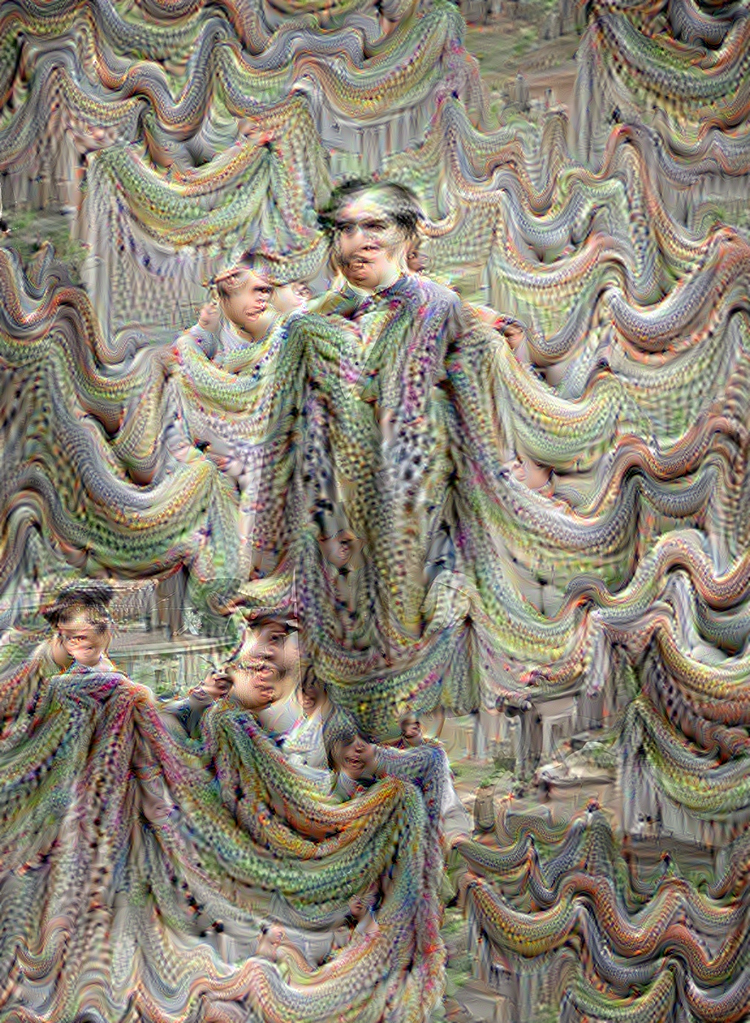

528 channels in inception_4d/output
channels used: [269  37  18 237]
[ 2.3829847   1.64862262  1.14056819  0.7890804   0.54591026  0.37767762]


In [57]:
# only if you have CUDA support, otherwise comment the following two lines and uncomment the third
caffe.set_device(0)
caffe.set_mode_gpu()
#caffe.set_mode_cpu()

# you can either put in a url here or a path to a local image, remember that the base path is the /caffee folder
img = loadImageFromUrlOrLocalPath('https://farm3.staticflickr.com/2852/9971283783_902cac8c15_o_d.jpg')
#img = getPerlinNoise(octaves=5, width=1024,height=1024)
# the target blob, see above for a list of potential blob ids
end = 'inception_4d/output'

#if you want reproducible results it's a good idea to seed the RNG before each run:
np.random.seed(seed=42)

# the smallest size the process starts with
# as a rule of thumb: the smaller this is the more abstract the final image gets
# and the bigger the emerging structures become
# if you use CUDA this size may not be smaller than 79 otherwise the kernel dies
firstOctaveImageSize = 200
octaveSteps = 6


#iterationsPerOctave = [int(i) for i in np.logspace(2.1, 1.2, num=octaveSteps)]
iterationsPerOctave = [int(i) for i in np.logspace(1.9, 1.4, num=octaveSteps)]

stepSizePerOctave = np.logspace(1.9, 1.1, num=octaveSteps) * 0.03

frame,keepIndices = deepdream(net, img, 
          iter_list = iterationsPerOctave,
          start_jitter=60., end_jitter=2.,
          step_list = stepSizePerOctave, # alternative a linear step decay can be used: start_step_size=1.55, end_step_size=0.05,
          recalculateKeepEachOctave = False, # if set to True the maximum activation indices will be different for every octave
          start_saturation = -0.01, end_saturation = 0.00, # a negative value will reduce the oversaturation, 0.0 makes no change
          invert = False, # inverts the activation layer - often results in black output
          keepIndices = None, # you can provide a list of class indices, e.g.  [424,69] - this overrides the keep(dropTop)
          keep = 4, dropTop = 50, # or tell how many indices to keep which are sorted by decreasing probability
          keepFactor = 1.0, #factor by which the kept activation layers get multiplied
          suppressFactor = 0.00000, #factor by which the dropped activation layers get multiplied
          gamma = 1.0, #gamma factor applied to activation layers
          octave_n = octaveSteps, 
          start_size = firstOctaveImageSize,
          blurSteps = 0, #blur iterations applied to activation layers
          maximumRadius = 0, #maximum filter radius applied to activation layers
          visualize=True,
          end=end)

showarray(frame)
print net.blobs[end].channels,"channels in",end
print "channels used:",keepIndices
print stepSizePerOctave